In [1]:
import os, sys, time, glob, random, argparse
import numpy as np
from copy import deepcopy
import torch
import torch.nn as nn

# XAutoDL 
from xautodl.config_utils import load_config, dict2config, configure2str
from xautodl.datasets import get_datasets, get_nas_search_loaders
from xautodl.procedures import (
    prepare_seed,
    prepare_logger,
    save_checkpoint,
    copy_checkpoint,
    get_optim_scheduler,
)
from xautodl.utils import get_model_infos, obtain_accuracy
from xautodl.log_utils import AverageMeter, time_string, convert_secs2time
from xautodl.models import get_search_spaces

from custom_models import get_cell_based_tiny_net
from custom_search_cells import NAS201SearchCell as SearchCell
from xautodl.models.cell_searchs.genotypes import Structure

# NB201
from nas_201_api import NASBench201API as API

import scipy.stats as stats
from tqdm import tqdm

2022-11-08 01:32:07.517799: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
parser = argparse.ArgumentParser("Random search for NAS.")
parser.add_argument("--data_path", type=str, default='../cifar.python', help="The path to dataset")
parser.add_argument("--dataset", type=str, default='cifar10',choices=["cifar10", "cifar100", "ImageNet16-120"], help="Choose between Cifar10/100 and ImageNet-16.")

# channels and number-of-cells
parser.add_argument("--search_space_name", type=str, default='nas-bench-201', help="The search space name.")
parser.add_argument("--config_path", type=str, default='./MY.config', help="The path to the configuration.")
parser.add_argument("--max_nodes", type=int, default=4, help="The maximum number of nodes.")
parser.add_argument("--channel", type=int, default=16, help="The number of channels.")
parser.add_argument("--num_cells", type=int, default=5, help="The number of cells in one stage.")
parser.add_argument("--select_num", type=int, default=100, help="The number of selected architectures to evaluate.")
parser.add_argument("--track_running_stats", type=int, default=0, choices=[0, 1], help="Whether use track_running_stats or not in the BN layer.")
# log
parser.add_argument("--workers", type=int, default=4, help="number of data loading workers")
parser.add_argument("--save_dir", type=str, default='./arch_level-use_pretrain', help="Folder to save checkpoints and log.")
# parser.add_argument("--arch_nas_dataset", type=str, default='../NAS-Bench-201-v1_1-096897.pth', help="The path to load the architecture dataset (tiny-nas-benchmark).")
parser.add_argument("--arch_nas_dataset", type=str, default=None, help="The path to load the architecture dataset (tiny-nas-benchmark).")
parser.add_argument("--print_freq", type=int, default=200, help="print frequency (default: 200)")
parser.add_argument("--rand_seed", type=int, default=None, help="manual seed")
args = parser.parse_args(args=[])
if args.rand_seed is None or args.rand_seed < 0:
    args.rand_seed = random.randint(1, 100000)

    
print(args.rand_seed)
print(args)
xargs=args

36953
Namespace(arch_nas_dataset=None, channel=16, config_path='./MY.config', data_path='../cifar.python', dataset='cifar10', max_nodes=4, num_cells=5, print_freq=200, rand_seed=36953, save_dir='./arch_level-use_pretrain', search_space_name='nas-bench-201', select_num=100, track_running_stats=0, workers=4)


In [3]:
assert torch.cuda.is_available(), "CUDA is not available."
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.set_num_threads(xargs.workers)
prepare_seed(xargs.rand_seed)
logger = prepare_logger(args)

Main Function with logger : Logger(dir=arch_level-use_pretrain, use-tf=False, writer=None)
Arguments : -------------------------------
arch_nas_dataset : None
channel          : 16
config_path      : ./MY.config
data_path        : ../cifar.python
dataset          : cifar10
max_nodes        : 4
num_cells        : 5
print_freq       : 200
rand_seed        : 36953
save_dir         : ./arch_level-use_pretrain
search_space_name : nas-bench-201
select_num       : 100
track_running_stats : 0
workers          : 4
Python  Version  : 3.7.13 (default, Mar 29 2022, 02:18:16)  [GCC 7.5.0]
Pillow  Version  : 9.0.1
PyTorch Version  : 1.12.0
cuDNN   Version  : 8302
CUDA available   : True
CUDA GPU numbers : 2
CUDA_VISIBLE_DEVICES : None


In [4]:
train_data, valid_data, xshape, class_num = get_datasets(xargs.dataset, xargs.data_path, -1)
config = load_config(xargs.config_path, {"class_num": class_num, "xshape": xshape}, logger)
search_loader, _, valid_loader = get_nas_search_loaders(train_data,
                                                        valid_data,
                                                        xargs.dataset,
                                                        "../configs/nas-benchmark/",
                                                        (config.batch_size, config.test_batch_size),
                                                        xargs.workers)
logger.log("||||||| {:10s} ||||||| Search-Loader-Num={:}, Valid-Loader-Num={:}, batch size={:}".format(
            xargs.dataset, len(search_loader), len(valid_loader), config.batch_size))
logger.log("||||||| {:10s} ||||||| Config={:}".format(xargs.dataset, config))

search_space = get_search_spaces("cell", xargs.search_space_name)
model_config = dict2config(
    {
        "name": "RANDOM",
        "C": xargs.channel,
        "N": xargs.num_cells,
        "max_nodes": xargs.max_nodes,
        "num_classes": class_num,
        "space": search_space,
        "affine": False,
        "track_running_stats": bool(xargs.track_running_stats),
    },
    None,
)
search_model = get_cell_based_tiny_net(model_config)

w_optimizer, w_scheduler, criterion = get_optim_scheduler(search_model.parameters(), config)

logger.log("w-optimizer : {:}".format(w_optimizer))
logger.log("w-scheduler : {:}".format(w_scheduler))
logger.log("criterion   : {:}".format(criterion))
# if xargs.arch_nas_dataset is None:
api = None
# else:
#     api = API(xargs.arch_nas_dataset)
logger.log("{:} create API = {:} done".format(time_string(), api))

last_info, model_base_path, model_best_path = (
    logger.path("info"),
    logger.path("model"),
    logger.path("best"),
)
network, criterion = torch.nn.DataParallel(search_model).cuda(), criterion.cuda()

if last_info.exists():  # automatically resume from previous checkpoint
    logger.log(
        "=> loading checkpoint of the last-info '{:}' start".format(last_info)
    )
    last_info = torch.load(last_info)
    start_epoch = last_info["epoch"]
    checkpoint = torch.load(last_info["last_checkpoint"])
    genotypes = checkpoint["genotypes"]
    valid_accuracies = checkpoint["valid_accuracies"]
    search_model.load_state_dict(checkpoint["search_model"])
    w_scheduler.load_state_dict(checkpoint["w_scheduler"])
    w_optimizer.load_state_dict(checkpoint["w_optimizer"])
    logger.log(
        "=> loading checkpoint of the last-info '{:}' start with {:}-th epoch.".format(
            last_info, start_epoch
        )
    )
else:
    logger.log("=> do not find the last-info file : {:}".format(last_info))
    start_epoch, valid_accuracies, genotypes = 0, {"best": -1}, {}

Files already downloaded and verified
Files already downloaded and verified
./MY.config
Configure(scheduler='cos', LR=0.025, eta_min=0.001, epochs=50, warmup=0, optim='SGD', decay=0.0005, momentum=0.9, nesterov=True, criterion='Softmax', batch_size=64, test_batch_size=512, class_num=10, xshape=(1, 3, 32, 32))
||||||| cifar10    ||||||| Search-Loader-Num=391, Valid-Loader-Num=49, batch size=64
||||||| cifar10    ||||||| Config=Configure(scheduler='cos', LR=0.025, eta_min=0.001, epochs=50, warmup=0, optim='SGD', decay=0.0005, momentum=0.9, nesterov=True, criterion='Softmax', batch_size=64, test_batch_size=512, class_num=10, xshape=(1, 3, 32, 32))
w-optimizer : SGD (
Parameter Group 0
    dampening: 0
    foreach: None
    initial_lr: 0.025
    lr: 0.025
    maximize: False
    momentum: 0.9
    nesterov: True
    weight_decay: 0.0005
)
w-scheduler : CosineAnnealingLR(warmup=0, max-epoch=50, current::epoch=0, iter=0.00, type=cosine, T-max=50, eta-min=0.001)
criterion   : CrossEntropyLoss(

In [5]:
def acc_confidence_robustness_metrics(network, inputs, targets):
    with torch.no_grad():
        # accuracy
        network.train()
        _, logits = network(inputs)
        val_top1, val_top5 = obtain_accuracy(logits.data, targets.data, topk=(1, 5))
        acc = val_top1
        
        # confidence
        prob = torch.nn.functional.softmax(logits, dim=1)
        one_hot_idx = torch.nn.functional.one_hot(targets)
        confidence = (prob[one_hot_idx==1].sum()) / inputs.size(0) * 100 # in percent
        
        # sensitivity
        _, noisy_logits = network(inputs + torch.randn_like(inputs)*0.1)
        kl_loss = torch.nn.KLDivLoss(reduction="batchmean")
        sensitivity = kl_loss(torch.nn.functional.log_softmax(noisy_logits, dim=1), torch.nn.functional.softmax(logits, dim=1))
        
        # robustness
        original_weights = deepcopy(network.state_dict())
        for m in network.modules():
            if isinstance(m, SearchCell):
                for p in m.parameters():
                    p.add_(torch.randn_like(p) * p.std()*0.3)
            
        _, noisy_logits = network(inputs)
        kl_loss = torch.nn.KLDivLoss(reduction="batchmean")
        robustness = -kl_loss(torch.nn.functional.log_softmax(noisy_logits, dim=1), torch.nn.functional.softmax(logits, dim=1))
        network.load_state_dict(original_weights)
                
        return acc.item(), confidence.item(), sensitivity.item(), robustness.item()
    
def step_sim_metric(network, criterion, inputs, targets):
#     inputs, targets = inputs[:64], targets[:64] # smaller batches
    original_dict = deepcopy(network.state_dict())
    optim_large_step = torch.optim.SGD(network.parameters(), lr=0.025)
    
    # single large step
    network.train()
    optim_large_step.zero_grad()
    _, logits = network(inputs)
    base_loss = criterion(logits, targets)
    base_loss.backward()
    optim_large_step.step()
    large_step_dict = deepcopy(network.state_dict())
    
    # multiple small steps
    network.load_state_dict(original_dict)
    optim_small_step = torch.optim.SGD(network.parameters(), lr=0.025/3)
    for i in range(3):
        optim_small_step.zero_grad()
        _, logits = network(inputs)
        base_loss = criterion(logits, targets)
        base_loss.backward()
        optim_small_step.step()
    small_step_dict = deepcopy(network.state_dict())
    scores = []
    for key in large_step_dict.keys():
        if ('weight' in key) and (original_dict[key].dim()==4):
            if (original_dict[key] != large_step_dict[key]).sum():
                large_step = large_step_dict[key] - original_dict[key]
                small_step = small_step_dict[key] - original_dict[key]
                co, ci, kh, kw = large_step.size()
                large_step = large_step.view(co, -1)
                small_step = small_step.view(co, -1)
                score = torch.nn.functional.cosine_similarity(large_step, small_step, dim=1)
                score = score.mean().item() * 100 # in percent
                scores.append(score)
    if len(scores)==0:
        step_sim = 100
        raise RuntimeError
    else:
        step_sim = np.mean(scores)
    
    # resume
    network.load_state_dict(original_dict)
            
    return step_sim

In [6]:
supernet_weights = torch.load("./250ep_cosine_supernet_cell_wise.pth")
network.load_state_dict(supernet_weights)

<All keys matched successfully>

In [8]:
# start training
start_time, search_time, epoch_time, total_epoch = (
    time.time(),
    AverageMeter(),
    AverageMeter(),
    config.epochs + config.warmup,
)

################# initialize
cells = []
for m in network.modules():
    if isinstance(m, SearchCell):
        cells.append(m)
num_cells = len(cells)
print("total number of nodes:{}".format(num_cells*xargs.max_nodes))
        
op_names = deepcopy(cells[0].op_names)
op_names_wo_none = deepcopy(op_names)
if "none" in op_names_wo_none:
    op_names_wo_none.remove("none")

genotypes = []
for i in range(1, xargs.max_nodes):
    xlist = []
    for j in range(i):
        node_str = "{:}<-{:}".format(i, j)
        if i-j==1:
            op_name = "skip_connect"
        else:
            op_name = "none"
        xlist.append((op_name, j))
    genotypes.append(tuple(xlist))
init_arch = Structure(genotypes)

for c in cells:
    c.arch_cache = init_arch

### gen possible connections of a target node
possible_connections = {}
for target_node_idx in range(1,xargs.max_nodes):
    possible_connections[target_node_idx] = list()
    xlists = []
    for src_node in range(target_node_idx):
        node_str = "{:}<-{:}".format(target_node_idx, src_node)
        # select possible ops
#         if target_node_idx - src_node == 1:
#             op_names_tmp = op_names_wo_none
#         else:
#             op_names_tmp = op_names
        op_names_tmp = op_names
            
        if len(xlists) == 0: # initial iteration
            for op_name in op_names_tmp:
                xlists.append([(op_name, src_node)])
        else:
            new_xlists = []
            for op_name in op_names_tmp:
                for xlist in xlists:
                    new_xlist = deepcopy(xlist)
                    new_xlist.append((op_name, src_node))
                    new_xlists.append(new_xlist)
            xlists = new_xlists
    for xlist in xlists:
        selected_ops = []
        for l in xlist:
            selected_ops.append(l[0])
        if sum(np.array(selected_ops) == "none") == len(selected_ops):
            continue
        possible_connections[target_node_idx].append(tuple(xlist))
    print("target_node:{}".format(target_node_idx), len(possible_connections[target_node_idx]))
        
### train while generating random architectures by mutating connections of a target node

## evaluation
network.train()
archs, metric_accs, metric_confidences, metric_sensitivities, metric_robustnesses, metric_step_sims = [], [], [], [], [], []
loader_iter = iter(valid_loader)

for arch_loop in tqdm(range(1000)):
    current_arch_list = []
    for target_cell_idx in range(num_cells):
        target_cell = cells[target_cell_idx]
        ###### random gen
        genotypes = []
        for n in range(1, xargs.max_nodes):
            genotypes.append(random.choice(possible_connections[n]))
        arch = Structure(genotypes)
        target_cell.arch_cache = arch
        current_arch_list.append(arch)
    ###### measure metrics
    try:
        inputs, targets = next(loader_iter)
    except:
        loader_iter = iter(valid_loader)
        inputs, targets = next(loader_iter)
    inputs, targets = inputs.cuda(non_blocking=True), targets.cuda(non_blocking=True)
    valid_acc, confidence, sensitivity, robustness = acc_confidence_robustness_metrics(network, inputs, targets)
    step_sim = step_sim_metric(network, criterion, inputs, targets)
    archs.append(current_arch_list)
    metric_accs.append(valid_acc)
    metric_confidences.append(confidence)
    metric_sensitivities.append(sensitivity)
    metric_robustnesses.append(robustness)
    metric_step_sims.append(step_sim)
rank_accs, rank_confidences, rank_sensitivities, rank_robustnesses, rank_step_sims = stats.rankdata(metric_accs), stats.rankdata(metric_confidences), stats.rankdata(metric_sensitivities), stats.rankdata(metric_robustnesses), stats.rankdata(metric_step_sims)
l = len(rank_accs)
rank_agg = np.log(rank_accs/l)+np.log(rank_confidences/l)+np.log(rank_sensitivities/l)+np.log(rank_robustnesses/l)+np.log(rank_step_sims/l)
best_idx = np.argmax(rank_agg)
best_arch, best_acc, best_conf, best_sensitivity, best_robust, best_step_sim = archs[best_idx], metric_accs[best_idx], metric_confidences[best_idx], metric_sensitivities[best_idx], metric_robustnesses[best_idx], metric_step_sims[best_idx]
logger.log("Found best arch with accuracy={:.2f}%, confidence={:.3f}%, sensitivity={:.3f}, robustness={:.3f}, step_sim={:.3f}".format(best_acc, best_conf, best_sensitivity, best_robust, best_step_sim))
for c, a in zip(cells, best_arch):
    c.arch_cache = a
            
best_archs = []
for c in cells:
    best_archs.append(c.arch_cache)
    
torch.save({"model":search_model.state_dict(), "best_archs":best_archs}, os.path.join(xargs.save_dir, "output.pth"))

for m in search_model.modules():
    if isinstance(m, SearchCell):
        logger.log(m.arch_cache)

logger.close()

Found best arch with accuracy=70.51%, confidence=55.433%, sensitivity=0.025, robustness=-0.011, step_sim=98.098
Structure(4 nodes with |skip_connect~0|+|nor_conv_1x1~0|skip_connect~1|+|nor_conv_1x1~0|nor_conv_1x1~1|nor_conv_3x3~2|)
Structure(4 nodes with |nor_conv_1x1~0|+|skip_connect~0|nor_conv_3x3~1|+|avg_pool_3x3~0|nor_conv_3x3~1|nor_conv_1x1~2|)
Structure(4 nodes with |skip_connect~0|+|avg_pool_3x3~0|nor_conv_1x1~1|+|skip_connect~0|avg_pool_3x3~1|nor_conv_1x1~2|)
Structure(4 nodes with |nor_conv_1x1~0|+|nor_conv_1x1~0|skip_connect~1|+|none~0|nor_conv_1x1~1|skip_connect~2|)
Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_1x1~0|nor_conv_1x1~1|+|nor_conv_1x1~0|skip_connect~1|nor_conv_3x3~2|)
Structure(4 nodes with |avg_pool_3x3~0|+|nor_conv_3x3~0|nor_conv_1x1~1|+|none~0|nor_conv_3x3~1|nor_conv_1x1~2|)
Structure(4 nodes with |nor_conv_1x1~0|+|nor_conv_1x1~0|nor_conv_3x3~1|+|nor_conv_3x3~0|nor_conv_3x3~1|nor_conv_1x1~2|)
Structure(4 nodes with |skip_connect~0|+|skip_connect~0|avg_pool

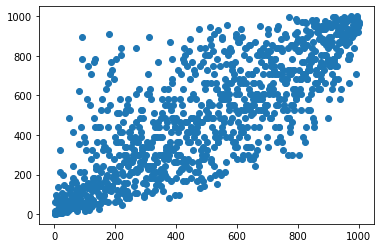

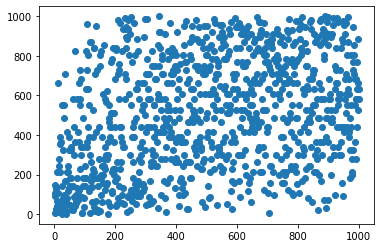

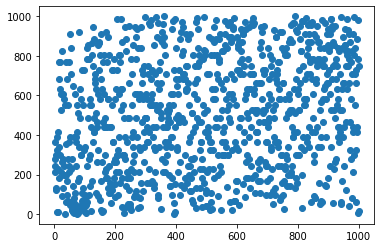

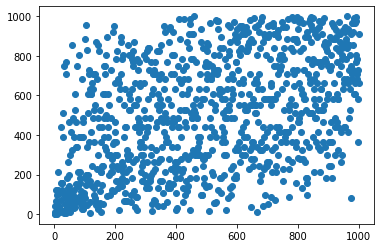

In [9]:
import matplotlib.pyplot as plt

plt.scatter(rank_confidences,rank_accs)
plt.show()

plt.scatter(rank_sensitivities,rank_accs)
plt.show()

plt.scatter(rank_robustnesses,rank_accs)
plt.show()

plt.scatter(rank_step_sims,rank_accs)
plt.show()

# Train a found model

In [10]:
trained_output = torch.load(os.path.join(xargs.save_dir, "output.pth"))
print(args)
args.save_dir = os.path.join(xargs.save_dir, "train")
print(args)

Namespace(arch_nas_dataset=None, channel=16, config_path='./MY.config', data_path='../cifar.python', dataset='cifar10', max_nodes=4, num_cells=5, print_freq=200, rand_seed=36953, save_dir='./arch_level-use_pretrain', search_space_name='nas-bench-201', select_num=100, track_running_stats=0, workers=4)
Namespace(arch_nas_dataset=None, channel=16, config_path='./MY.config', data_path='../cifar.python', dataset='cifar10', max_nodes=4, num_cells=5, print_freq=200, rand_seed=36953, save_dir='./arch_level-use_pretrain/train', search_space_name='nas-bench-201', select_num=100, track_running_stats=0, workers=4)


In [11]:
print(config)

Configure(scheduler='cos', LR=0.025, eta_min=0.001, epochs=50, warmup=0, optim='SGD', decay=0.0005, momentum=0.9, nesterov=True, criterion='Softmax', batch_size=64, test_batch_size=512, class_num=10, xshape=(1, 3, 32, 32))


In [12]:
logger = prepare_logger(args)

# cifar_train_config_path = "./MY.config"
cifar_train_config_path = "../configs/nas-benchmark/CIFAR.config"
###
train_data, test_data, xshape, class_num = get_datasets(xargs.dataset, xargs.data_path, -1)
config = load_config(cifar_train_config_path, {"class_num": class_num, "xshape": xshape}, logger)

train_loader = torch.utils.data.DataLoader(
            train_data,
            batch_size=config.batch_size,
            shuffle=True,
            num_workers=xargs.workers,
            pin_memory=True,)

test_loader = torch.utils.data.DataLoader(
            test_data,
            batch_size=config.batch_size,
            shuffle=True,
            num_workers=xargs.workers,
            pin_memory=True,)

# search_loader, _, valid_loader = get_nas_search_loaders(train_data,
#                                                         valid_data,
#                                                         xargs.dataset,
#                                                         "../configs/nas-benchmark/",
#                                                         (config.batch_size, config.batch_size),
#                                                         xargs.workers)
logger.log("||||||| {:10s} ||||||| Train-Loader-Num={:}, Test-Loader-Num={:}, batch size={:}".format(
            xargs.dataset, len(train_loader), len(test_loader), config.batch_size))
logger.log("||||||| {:10s} ||||||| Config={:}".format(xargs.dataset, config))

search_space = get_search_spaces("cell", xargs.search_space_name)
model_config = dict2config(
    {
        "name": "RANDOM",
        "C": xargs.channel,
        "N": xargs.num_cells,
        "max_nodes": xargs.max_nodes,
        "num_classes": class_num,
        "space": search_space,
        "affine": False,
        "track_running_stats": True, # true for eval
    },
    None,
)
search_model = get_cell_based_tiny_net(model_config)

### load
# trained_output = torch.load(os.path.join(xargs.save_dir, "output.pth"))
# search_model.load_state_dict(trained_output['model'], strict=False)
best_archs = trained_output['best_archs']
i=0
for m in search_model.modules():
    if isinstance(m, SearchCell):
        m.arch_cache = best_archs[i]
        i += 1
for m in network.modules():
    if isinstance(m, SearchCell):
        print(m.arch_cache)
###

w_optimizer, w_scheduler, criterion = get_optim_scheduler(search_model.parameters(), config)

logger.log("w-optimizer : {:}".format(w_optimizer))
logger.log("w-scheduler : {:}".format(w_scheduler))
logger.log("criterion   : {:}".format(criterion))

network, criterion = torch.nn.DataParallel(search_model).cuda(), criterion.cuda()

last_info, model_base_path, model_best_path = (
    logger.path("info"),
    logger.path("model"),
    logger.path("best"),
)

start_epoch, valid_accuracies, genotypes = 0, {"best": -1}, {}

Main Function with logger : Logger(dir=arch_level-use_pretrain/train, use-tf=False, writer=None)
Arguments : -------------------------------
arch_nas_dataset : None
channel          : 16
config_path      : ./MY.config
data_path        : ../cifar.python
dataset          : cifar10
max_nodes        : 4
num_cells        : 5
print_freq       : 200
rand_seed        : 36953
save_dir         : ./arch_level-use_pretrain/train
search_space_name : nas-bench-201
select_num       : 100
track_running_stats : 0
workers          : 4
Python  Version  : 3.7.13 (default, Mar 29 2022, 02:18:16)  [GCC 7.5.0]
Pillow  Version  : 9.0.1
PyTorch Version  : 1.12.0
cuDNN   Version  : 8302
CUDA available   : True
CUDA GPU numbers : 2
CUDA_VISIBLE_DEVICES : None
Files already downloaded and verified
Files already downloaded and verified
../configs/nas-benchmark/CIFAR.config
Configure(scheduler='cos', eta_min=0.0, epochs=200, warmup=0, optim='SGD', LR=0.1, decay=0.0005, momentum=0.9, nesterov=True, criterion='Softma

In [13]:
# def search_func_one_arch(xloader, network, criterion, scheduler, w_optimizer, epoch_str, print_freq, logger):
#     data_time, batch_time = AverageMeter(), AverageMeter()
#     base_losses, base_top1, base_top5 = AverageMeter(), AverageMeter(), AverageMeter()
#     network.train()
#     end = time.time()
#     for step, (base_inputs, base_targets, arch_inputs, arch_targets) in enumerate(
#         xloader
#     ):
#         scheduler.update(None, 1.0 * step / len(xloader))
#         base_targets = base_targets.cuda(non_blocking=True)
#         arch_targets = arch_targets.cuda(non_blocking=True)
#         # measure data loading time
#         data_time.update(time.time() - end)

#         w_optimizer.zero_grad()
#         _, logits = network(base_inputs)
#         base_loss = criterion(logits, base_targets)
#         base_loss.backward()
#         nn.utils.clip_grad_norm_(network.parameters(), 5)
#         w_optimizer.step()
#         # record
#         base_prec1, base_prec5 = obtain_accuracy(
#             logits.data, base_targets.data, topk=(1, 5)
#         )
#         base_losses.update(base_loss.item(), base_inputs.size(0))
#         base_top1.update(base_prec1.item(), base_inputs.size(0))
#         base_top5.update(base_prec5.item(), base_inputs.size(0))

#         # measure elapsed time
#         batch_time.update(time.time() - end)
#         end = time.time()

#         if step % print_freq == 0 or step + 1 == len(xloader):
#             Sstr = (
#                 "*SEARCH* "
#                 + time_string()
#                 + " [{:}][{:03d}/{:03d}]".format(epoch_str, step, len(xloader))
#             )
#             Tstr = "Time {batch_time.val:.2f} ({batch_time.avg:.2f}) Data {data_time.val:.2f} ({data_time.avg:.2f})".format(
#                 batch_time=batch_time, data_time=data_time
#             )
#             Wstr = "Base [Loss {loss.val:.3f} ({loss.avg:.3f})  Prec@1 {top1.val:.2f} ({top1.avg:.2f}) Prec@5 {top5.val:.2f} ({top5.avg:.2f})]".format(
#                 loss=base_losses, top1=base_top1, top5=base_top5
#             )
#             logger.log(Sstr + " " + Tstr + " " + Wstr)
#     return base_losses.avg, base_top1.avg, base_top5.avg

def train_func_one_arch(xloader, network, criterion, scheduler, w_optimizer, epoch_str, print_freq, logger):
    data_time, batch_time = AverageMeter(), AverageMeter()
    base_losses, base_top1, base_top5 = AverageMeter(), AverageMeter(), AverageMeter()
    network.train()
    end = time.time()
    for step, (base_inputs, base_targets) in enumerate(
        xloader
    ):
        scheduler.update(None, 1.0 * step / len(xloader))
        base_targets = base_targets.cuda(non_blocking=True)
        # measure data loading time
        data_time.update(time.time() - end)

        w_optimizer.zero_grad()
        _, logits = network(base_inputs)
        base_loss = criterion(logits, base_targets)
        base_loss.backward()
        nn.utils.clip_grad_norm_(network.parameters(), 5)
        w_optimizer.step()
        # record
        base_prec1, base_prec5 = obtain_accuracy(
            logits.data, base_targets.data, topk=(1, 5)
        )
        base_losses.update(base_loss.item(), base_inputs.size(0))
        base_top1.update(base_prec1.item(), base_inputs.size(0))
        base_top5.update(base_prec5.item(), base_inputs.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if step % print_freq == 0 or step + 1 == len(xloader):
            Sstr = (
                "*SEARCH* "
                + time_string()
                + " [{:}][{:03d}/{:03d}]".format(epoch_str, step, len(xloader))
            )
            Tstr = "Time {batch_time.val:.2f} ({batch_time.avg:.2f}) Data {data_time.val:.2f} ({data_time.avg:.2f})".format(
                batch_time=batch_time, data_time=data_time
            )
            Wstr = "Base [Loss {loss.val:.3f} ({loss.avg:.3f})  Prec@1 {top1.val:.2f} ({top1.avg:.2f}) Prec@5 {top5.val:.2f} ({top5.avg:.2f})]".format(
                loss=base_losses, top1=base_top1, top5=base_top5
            )
            logger.log(Sstr + " " + Tstr + " " + Wstr)
    return base_losses.avg, base_top1.avg, base_top5.avg

def valid_func_one_arch(xloader, network, criterion):
    data_time, batch_time = AverageMeter(), AverageMeter()
    arch_losses, arch_top1, arch_top5 = AverageMeter(), AverageMeter(), AverageMeter()
    network.eval()
    end = time.time()
    with torch.no_grad():
        for step, (arch_inputs, arch_targets) in enumerate(xloader):
            arch_targets = arch_targets.cuda(non_blocking=True)
            # measure data loading time
            data_time.update(time.time() - end)
            # prediction

#             network.module.random_genotype_per_cell(True)
            _, logits = network(arch_inputs)
            arch_loss = criterion(logits, arch_targets)
            # record
            arch_prec1, arch_prec5 = obtain_accuracy(
                logits.data, arch_targets.data, topk=(1, 5)
            )
            arch_losses.update(arch_loss.item(), arch_inputs.size(0))
            arch_top1.update(arch_prec1.item(), arch_inputs.size(0))
            arch_top5.update(arch_prec5.item(), arch_inputs.size(0))
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
    return arch_losses.avg, arch_top1.avg, arch_top5.avg

In [14]:
start_time, search_time, epoch_time, total_epoch = (
    time.time(),
    AverageMeter(),
    AverageMeter(),
    config.epochs + config.warmup,
)
for epoch in range(0, total_epoch):
    w_scheduler.update(epoch, 0.0)
    need_time = "Time Left: {:}".format(
        convert_secs2time(epoch_time.val * (total_epoch - epoch), True)
    )
    epoch_str = "{:03d}-{:03d}".format(epoch, total_epoch)
    logger.log(
        "\n[Search the {:}-th epoch] {:}, LR={:}".format(
            epoch_str, need_time, min(w_scheduler.get_lr())
        )
    )

    # selected_arch = search_find_best(valid_loader, network, criterion, xargs.select_num)
    search_w_loss, search_w_top1, search_w_top5 = train_func_one_arch(
        train_loader,
        network,
        criterion,
        w_scheduler,
        w_optimizer,
        epoch_str,
        xargs.print_freq,
        logger,
    )
    search_time.update(time.time() - start_time)
    logger.log(
        "[{:}] searching : loss={:.2f}, accuracy@1={:.2f}%, accuracy@5={:.2f}%, time-cost={:.1f} s".format(
            epoch_str, search_w_loss, search_w_top1, search_w_top5, search_time.sum
        )
    )
    valid_a_loss, valid_a_top1, valid_a_top5 = valid_func_one_arch(
        test_loader, network, criterion
    )
    logger.log(
        "[{:}] evaluate  : loss={:.2f}, accuracy@1={:.2f}%, accuracy@5={:.2f}%".format(
            epoch_str, valid_a_loss, valid_a_top1, valid_a_top5
        )
    )
    
    # check the best accuracy
    valid_accuracies[epoch] = valid_a_top1
    if valid_a_top1 > valid_accuracies["best"]:
        valid_accuracies["best"] = valid_a_top1
        find_best = True
    else:
        find_best = False

    # save checkpoint
    save_path = save_checkpoint(
        {
            "epoch": epoch + 1,
            "args": deepcopy(xargs),
            "search_model": search_model.state_dict(),
            "w_optimizer": w_optimizer.state_dict(),
            "w_scheduler": w_scheduler.state_dict(),
            "genotypes": genotypes,
            "valid_accuracies": valid_accuracies,
        },
        model_base_path,
        logger,
    )
    last_info = save_checkpoint(
        {
            "epoch": epoch + 1,
            "args": deepcopy(args),
            "last_checkpoint": save_path,
        },
        logger.path("info"),
        logger,
    )
    if find_best:
        logger.log(
            "<<<--->>> The {:}-th epoch : find the highest validation accuracy : {:.2f}%.".format(
                epoch_str, valid_a_top1
            )
        )
        copy_checkpoint(model_base_path, model_best_path, logger)
    if api is not None:
        logger.log("{:}".format(api.query_by_arch(genotypes[epoch], "200")))
    # measure elapsed time
    epoch_time.update(time.time() - start_time)
    start_time = time.time()

logger.close()


[Search the 000-200-th epoch] Time Left: [00:00:00], LR=0.1
*SEARCH* [2022-11-08 01:57:56] [000-200][000/196] Time 0.55 (0.55) Data 0.37 (0.37) Base [Loss 2.327 (2.327)  Prec@1 8.59 (8.59) Prec@5 51.95 (51.95)]
*SEARCH* [2022-11-08 01:58:22] [000-200][195/196] Time 0.09 (0.13) Data 0.00 (0.00) Base [Loss 1.628 (1.661)  Prec@1 42.50 (37.90) Prec@5 90.00 (87.41)]
[000-200] searching : loss=1.66, accuracy@1=37.90%, accuracy@5=87.41%, time-cost=26.4 s
[000-200] evaluate  : loss=1.45, accuracy@1=46.75%, accuracy@5=92.33%
save checkpoint into arch_level-use_pretrain/train/checkpoint/seed-36953-basic.pth
save checkpoint into arch_level-use_pretrain/train/seed-36953-last-info.pth
<<<--->>> The 000-200-th epoch : find the highest validation accuracy : 46.75%.
copy the file from arch_level-use_pretrain/train/checkpoint/seed-36953-basic.pth into arch_level-use_pretrain/train/checkpoint/seed-36953-best.pth

[Search the 001-200-th epoch] Time Left: [01:37:25], LR=0.09999383162408304
*SEARCH* [2022

*SEARCH* [2022-11-08 02:01:10] [007-200][000/196] Time 0.50 (0.50) Data 0.38 (0.38) Base [Loss 0.619 (0.619)  Prec@1 77.34 (77.34) Prec@5 98.83 (98.83)]
*SEARCH* [2022-11-08 02:01:30] [007-200][195/196] Time 0.08 (0.10) Data 0.00 (0.00) Base [Loss 0.861 (0.635)  Prec@1 72.50 (77.92) Prec@5 95.00 (98.79)]
[007-200] searching : loss=0.64, accuracy@1=77.92%, accuracy@5=98.79%, time-cost=188.3 s
[007-200] evaluate  : loss=1.57, accuracy@1=56.74%, accuracy@5=96.51%
Find arch_level-use_pretrain/train/checkpoint/seed-36953-basic.pth exist, delete is at first before saving
save checkpoint into arch_level-use_pretrain/train/checkpoint/seed-36953-basic.pth
Find arch_level-use_pretrain/train/seed-36953-last-info.pth exist, delete is at first before saving
save checkpoint into arch_level-use_pretrain/train/seed-36953-last-info.pth

[Search the 008-200-th epoch] Time Left: [01:18:05], LR=0.0996057350657239
*SEARCH* [2022-11-08 02:01:34] [008-200][000/196] Time 0.62 (0.62) Data 0.45 (0.45) Base [Los

*SEARCH* [2022-11-08 02:05:42] [016-200][000/196] Time 0.47 (0.47) Data 0.35 (0.35) Base [Loss 0.523 (0.523)  Prec@1 82.42 (82.42) Prec@5 99.22 (99.22)]
*SEARCH* [2022-11-08 02:06:14] [016-200][195/196] Time 0.15 (0.16) Data 0.00 (0.00) Base [Loss 0.576 (0.502)  Prec@1 81.25 (82.65) Prec@5 97.50 (99.20)]
[016-200] searching : loss=0.50, accuracy@1=82.65%, accuracy@5=99.20%, time-cost=441.5 s
[016-200] evaluate  : loss=0.65, accuracy@1=78.76%, accuracy@5=99.01%
Find arch_level-use_pretrain/train/checkpoint/seed-36953-basic.pth exist, delete is at first before saving
save checkpoint into arch_level-use_pretrain/train/checkpoint/seed-36953-basic.pth
Find arch_level-use_pretrain/train/seed-36953-last-info.pth exist, delete is at first before saving
save checkpoint into arch_level-use_pretrain/train/seed-36953-last-info.pth
<<<--->>> The 016-200-th epoch : find the highest validation accuracy : 78.76%.
Find arch_level-use_pretrain/train/checkpoint/seed-36953-best.pth exist, delete is at fir

[024-200] evaluate  : loss=0.87, accuracy@1=73.04%, accuracy@5=97.70%
Find arch_level-use_pretrain/train/checkpoint/seed-36953-basic.pth exist, delete is at first before saving
save checkpoint into arch_level-use_pretrain/train/checkpoint/seed-36953-basic.pth
Find arch_level-use_pretrain/train/seed-36953-last-info.pth exist, delete is at first before saving
save checkpoint into arch_level-use_pretrain/train/seed-36953-last-info.pth

[Search the 025-200-th epoch] Time Left: [01:15:17], LR=0.09619397662556434
*SEARCH* [2022-11-08 02:10:01] [025-200][000/196] Time 0.61 (0.61) Data 0.44 (0.44) Base [Loss 0.451 (0.451)  Prec@1 83.98 (83.98) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-08 02:10:25] [025-200][195/196] Time 0.08 (0.12) Data 0.00 (0.00) Base [Loss 0.456 (0.454)  Prec@1 86.25 (84.53) Prec@5 98.75 (99.33)]
[025-200] searching : loss=0.45, accuracy@1=84.53%, accuracy@5=99.33%, time-cost=656.7 s
[025-200] evaluate  : loss=0.91, accuracy@1=72.65%, accuracy@5=97.91%
Find arch_level-use_

*SEARCH* [2022-11-08 02:14:21] [033-200][195/196] Time 0.13 (0.15) Data 0.00 (0.00) Base [Loss 0.299 (0.414)  Prec@1 92.50 (85.74) Prec@5 100.00 (99.46)]
[033-200] searching : loss=0.41, accuracy@1=85.74%, accuracy@5=99.46%, time-cost=863.5 s
[033-200] evaluate  : loss=0.72, accuracy@1=78.02%, accuracy@5=98.41%
Find arch_level-use_pretrain/train/checkpoint/seed-36953-basic.pth exist, delete is at first before saving
save checkpoint into arch_level-use_pretrain/train/checkpoint/seed-36953-basic.pth
Find arch_level-use_pretrain/train/seed-36953-last-info.pth exist, delete is at first before saving
save checkpoint into arch_level-use_pretrain/train/seed-36953-last-info.pth

[Search the 034-200-th epoch] Time Left: [01:32:06], LR=0.09303710135019719
*SEARCH* [2022-11-08 02:14:25] [034-200][000/196] Time 0.51 (0.51) Data 0.34 (0.34) Base [Loss 0.470 (0.470)  Prec@1 81.64 (81.64) Prec@5 99.61 (99.61)]
*SEARCH* [2022-11-08 02:14:55] [034-200][195/196] Time 0.23 (0.16) Data 0.00 (0.00) Base [L

*SEARCH* [2022-11-08 02:18:16] [042-200][000/196] Time 0.52 (0.52) Data 0.35 (0.35) Base [Loss 0.407 (0.407)  Prec@1 85.16 (85.16) Prec@5 99.22 (99.22)]
*SEARCH* [2022-11-08 02:18:41] [042-200][195/196] Time 0.16 (0.13) Data 0.00 (0.00) Base [Loss 0.518 (0.395)  Prec@1 77.50 (86.50) Prec@5 98.75 (99.47)]
[042-200] searching : loss=0.39, accuracy@1=86.50%, accuracy@5=99.47%, time-cost=1092.7 s
[042-200] evaluate  : loss=0.69, accuracy@1=78.25%, accuracy@5=99.02%
Find arch_level-use_pretrain/train/checkpoint/seed-36953-basic.pth exist, delete is at first before saving
save checkpoint into arch_level-use_pretrain/train/checkpoint/seed-36953-basic.pth
Find arch_level-use_pretrain/train/seed-36953-last-info.pth exist, delete is at first before saving
save checkpoint into arch_level-use_pretrain/train/seed-36953-last-info.pth

[Search the 043-200-th epoch] Time Left: [01:14:03], LR=0.08902152036691649
*SEARCH* [2022-11-08 02:18:45] [043-200][000/196] Time 0.51 (0.51) Data 0.34 (0.34) Base [L

*SEARCH* [2022-11-08 02:22:38] [051-200][000/196] Time 0.51 (0.51) Data 0.39 (0.39) Base [Loss 0.346 (0.346)  Prec@1 87.11 (87.11) Prec@5 99.22 (99.22)]
*SEARCH* [2022-11-08 02:22:58] [051-200][195/196] Time 0.08 (0.10) Data 0.00 (0.00) Base [Loss 0.375 (0.365)  Prec@1 90.00 (87.39) Prec@5 100.00 (99.54)]
[051-200] searching : loss=0.36, accuracy@1=87.39%, accuracy@5=99.54%, time-cost=1315.8 s
[051-200] evaluate  : loss=0.69, accuracy@1=78.57%, accuracy@5=98.66%
Find arch_level-use_pretrain/train/checkpoint/seed-36953-basic.pth exist, delete is at first before saving
save checkpoint into arch_level-use_pretrain/train/checkpoint/seed-36953-basic.pth
Find arch_level-use_pretrain/train/seed-36953-last-info.pth exist, delete is at first before saving
save checkpoint into arch_level-use_pretrain/train/seed-36953-last-info.pth

[Search the 052-200-th epoch] Time Left: [01:01:18], LR=0.08422735529643444
*SEARCH* [2022-11-08 02:23:03] [052-200][000/196] Time 0.56 (0.56) Data 0.45 (0.45) Base [

*SEARCH* [2022-11-08 02:26:40] [060-200][000/196] Time 0.54 (0.54) Data 0.42 (0.42) Base [Loss 0.400 (0.400)  Prec@1 83.98 (83.98) Prec@5 99.61 (99.61)]
*SEARCH* [2022-11-08 02:27:00] [060-200][195/196] Time 0.08 (0.10) Data 0.00 (0.00) Base [Loss 0.244 (0.353)  Prec@1 92.50 (87.88) Prec@5 100.00 (99.62)]
[060-200] searching : loss=0.35, accuracy@1=87.88%, accuracy@5=99.62%, time-cost=1523.2 s
[060-200] evaluate  : loss=0.56, accuracy@1=82.09%, accuracy@5=98.88%
Find arch_level-use_pretrain/train/checkpoint/seed-36953-basic.pth exist, delete is at first before saving
save checkpoint into arch_level-use_pretrain/train/checkpoint/seed-36953-basic.pth
Find arch_level-use_pretrain/train/seed-36953-last-info.pth exist, delete is at first before saving
save checkpoint into arch_level-use_pretrain/train/seed-36953-last-info.pth

[Search the 061-200-th epoch] Time Left: [00:54:26], LR=0.07875026260216395
*SEARCH* [2022-11-08 02:27:03] [061-200][000/196] Time 0.48 (0.48) Data 0.36 (0.36) Base [

*SEARCH* [2022-11-08 02:30:38] [069-200][000/196] Time 0.52 (0.52) Data 0.40 (0.40) Base [Loss 0.255 (0.255)  Prec@1 91.02 (91.02) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-08 02:31:00] [069-200][195/196] Time 0.08 (0.11) Data 0.00 (0.00) Base [Loss 0.392 (0.328)  Prec@1 86.25 (88.75) Prec@5 100.00 (99.63)]
[069-200] searching : loss=0.33, accuracy@1=88.75%, accuracy@5=99.63%, time-cost=1732.3 s
[069-200] evaluate  : loss=0.64, accuracy@1=80.00%, accuracy@5=99.02%
Find arch_level-use_pretrain/train/checkpoint/seed-36953-basic.pth exist, delete is at first before saving
save checkpoint into arch_level-use_pretrain/train/checkpoint/seed-36953-basic.pth
Find arch_level-use_pretrain/train/seed-36953-last-info.pth exist, delete is at first before saving
save checkpoint into arch_level-use_pretrain/train/seed-36953-last-info.pth

[Search the 070-200-th epoch] Time Left: [00:57:33], LR=0.07269952498697733
*SEARCH* [2022-11-08 02:31:04] [070-200][000/196] Time 0.48 (0.48) Data 0.36 (0.36) Base

*SEARCH* [2022-11-08 02:34:57] [078-200][000/196] Time 0.53 (0.53) Data 0.36 (0.36) Base [Loss 0.329 (0.329)  Prec@1 90.23 (90.23) Prec@5 99.61 (99.61)]
*SEARCH* [2022-11-08 02:35:28] [078-200][195/196] Time 0.15 (0.16) Data 0.00 (0.00) Base [Loss 0.518 (0.313)  Prec@1 85.00 (89.26) Prec@5 97.50 (99.65)]
[078-200] searching : loss=0.31, accuracy@1=89.26%, accuracy@5=99.65%, time-cost=1971.5 s
[078-200] evaluate  : loss=0.64, accuracy@1=79.38%, accuracy@5=98.93%
Find arch_level-use_pretrain/train/checkpoint/seed-36953-basic.pth exist, delete is at first before saving
save checkpoint into arch_level-use_pretrain/train/checkpoint/seed-36953-basic.pth
Find arch_level-use_pretrain/train/seed-36953-last-info.pth exist, delete is at first before saving
save checkpoint into arch_level-use_pretrain/train/seed-36953-last-info.pth

[Search the 079-200-th epoch] Time Left: [01:10:22], LR=0.06619587090990747
*SEARCH* [2022-11-08 02:35:32] [079-200][000/196] Time 0.51 (0.51) Data 0.34 (0.34) Base [L

*SEARCH* [2022-11-08 02:39:36] [087-200][000/196] Time 0.56 (0.56) Data 0.45 (0.45) Base [Loss 0.262 (0.262)  Prec@1 92.19 (92.19) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-08 02:39:55] [087-200][195/196] Time 0.08 (0.10) Data 0.00 (0.00) Base [Loss 0.386 (0.298)  Prec@1 86.25 (89.67) Prec@5 98.75 (99.72)]
[087-200] searching : loss=0.30, accuracy@1=89.67%, accuracy@5=99.72%, time-cost=2208.1 s
[087-200] evaluate  : loss=0.57, accuracy@1=82.35%, accuracy@5=99.16%
Find arch_level-use_pretrain/train/checkpoint/seed-36953-basic.pth exist, delete is at first before saving
save checkpoint into arch_level-use_pretrain/train/checkpoint/seed-36953-basic.pth
Find arch_level-use_pretrain/train/seed-36953-last-info.pth exist, delete is at first before saving
save checkpoint into arch_level-use_pretrain/train/seed-36953-last-info.pth

[Search the 088-200-th epoch] Time Left: [00:43:58], LR=0.05936906572928624
*SEARCH* [2022-11-08 02:39:59] [088-200][000/196] Time 0.51 (0.51) Data 0.34 (0.34) Base 

*SEARCH* [2022-11-08 02:43:51] [096-200][000/196] Time 0.57 (0.57) Data 0.40 (0.40) Base [Loss 0.258 (0.258)  Prec@1 89.45 (89.45) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-08 02:44:15] [096-200][195/196] Time 0.08 (0.13) Data 0.00 (0.00) Base [Loss 0.252 (0.272)  Prec@1 91.25 (90.67) Prec@5 100.00 (99.75)]
[096-200] searching : loss=0.27, accuracy@1=90.67%, accuracy@5=99.75%, time-cost=2436.3 s
[096-200] evaluate  : loss=0.63, accuracy@1=81.08%, accuracy@5=98.78%
Find arch_level-use_pretrain/train/checkpoint/seed-36953-basic.pth exist, delete is at first before saving
save checkpoint into arch_level-use_pretrain/train/checkpoint/seed-36953-basic.pth
Find arch_level-use_pretrain/train/seed-36953-last-info.pth exist, delete is at first before saving
save checkpoint into arch_level-use_pretrain/train/seed-36953-last-info.pth

[Search the 097-200-th epoch] Time Left: [00:50:54], LR=0.052355322535482134
*SEARCH* [2022-11-08 02:44:20] [097-200][000/196] Time 0.50 (0.50) Data 0.38 (0.38) Bas

*SEARCH* [2022-11-08 02:48:13] [105-200][195/196] Time 0.08 (0.10) Data 0.00 (0.00) Base [Loss 0.261 (0.251)  Prec@1 88.75 (91.39) Prec@5 100.00 (99.81)]
[105-200] searching : loss=0.25, accuracy@1=91.39%, accuracy@5=99.81%, time-cost=2639.3 s
[105-200] evaluate  : loss=0.55, accuracy@1=83.23%, accuracy@5=99.41%
Find arch_level-use_pretrain/train/checkpoint/seed-36953-basic.pth exist, delete is at first before saving
save checkpoint into arch_level-use_pretrain/train/checkpoint/seed-36953-basic.pth
Find arch_level-use_pretrain/train/seed-36953-last-info.pth exist, delete is at first before saving
save checkpoint into arch_level-use_pretrain/train/seed-36953-last-info.pth

[Search the 106-200-th epoch] Time Left: [00:38:52], LR=0.04529458433407429
*SEARCH* [2022-11-08 02:48:18] [106-200][000/196] Time 0.51 (0.51) Data 0.39 (0.39) Base [Loss 0.254 (0.254)  Prec@1 90.62 (90.62) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-08 02:48:38] [106-200][195/196] Time 0.08 (0.10) Data 0.00 (0.00) Base

*SEARCH* [2022-11-08 02:52:05] [114-200][000/196] Time 0.57 (0.57) Data 0.39 (0.39) Base [Loss 0.248 (0.248)  Prec@1 91.80 (91.80) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-08 02:52:31] [114-200][195/196] Time 0.08 (0.14) Data 0.00 (0.00) Base [Loss 0.230 (0.230)  Prec@1 93.75 (92.05) Prec@5 100.00 (99.83)]
[114-200] searching : loss=0.23, accuracy@1=92.05%, accuracy@5=99.83%, time-cost=2863.2 s
[114-200] evaluate  : loss=0.44, accuracy@1=86.39%, accuracy@5=99.63%
Find arch_level-use_pretrain/train/checkpoint/seed-36953-basic.pth exist, delete is at first before saving
save checkpoint into arch_level-use_pretrain/train/checkpoint/seed-36953-basic.pth
Find arch_level-use_pretrain/train/seed-36953-last-info.pth exist, delete is at first before saving
save checkpoint into arch_level-use_pretrain/train/seed-36953-last-info.pth

[Search the 115-200-th epoch] Time Left: [00:41:53], LR=0.038327731807204724
*SEARCH* [2022-11-08 02:52:35] [115-200][000/196] Time 0.51 (0.51) Data 0.34 (0.34) Bas

[122-200] evaluate  : loss=0.39, accuracy@1=87.63%, accuracy@5=99.58%
Find arch_level-use_pretrain/train/checkpoint/seed-36953-basic.pth exist, delete is at first before saving
save checkpoint into arch_level-use_pretrain/train/checkpoint/seed-36953-basic.pth
Find arch_level-use_pretrain/train/seed-36953-last-info.pth exist, delete is at first before saving
save checkpoint into arch_level-use_pretrain/train/seed-36953-last-info.pth
<<<--->>> The 122-200-th epoch : find the highest validation accuracy : 87.63%.
Find arch_level-use_pretrain/train/checkpoint/seed-36953-best.pth exist, delete is at first before saving
copy the file from arch_level-use_pretrain/train/checkpoint/seed-36953-basic.pth into arch_level-use_pretrain/train/checkpoint/seed-36953-best.pth

[Search the 123-200-th epoch] Time Left: [00:33:06], LR=0.03232625781103715
*SEARCH* [2022-11-08 02:56:27] [123-200][000/196] Time 0.46 (0.46) Data 0.34 (0.34) Base [Loss 0.248 (0.248)  Prec@1 91.02 (91.02) Prec@5 99.61 (99.61)]
*

*SEARCH* [2022-11-08 03:00:16] [131-200][000/196] Time 0.57 (0.57) Data 0.39 (0.39) Base [Loss 0.190 (0.190)  Prec@1 93.36 (93.36) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-08 03:00:40] [131-200][195/196] Time 0.08 (0.12) Data 0.00 (0.00) Base [Loss 0.209 (0.183)  Prec@1 95.00 (93.63) Prec@5 100.00 (99.91)]
[131-200] searching : loss=0.18, accuracy@1=93.63%, accuracy@5=99.91%, time-cost=3292.1 s
[131-200] evaluate  : loss=0.44, accuracy@1=86.48%, accuracy@5=99.46%
Find arch_level-use_pretrain/train/checkpoint/seed-36953-basic.pth exist, delete is at first before saving
save checkpoint into arch_level-use_pretrain/train/checkpoint/seed-36953-basic.pth
Find arch_level-use_pretrain/train/seed-36953-last-info.pth exist, delete is at first before saving
save checkpoint into arch_level-use_pretrain/train/seed-36953-last-info.pth

[Search the 132-200-th epoch] Time Left: [00:31:59], LR=0.02591231629491423
*SEARCH* [2022-11-08 03:00:44] [132-200][000/196] Time 0.47 (0.47) Data 0.34 (0.34) Base

*SEARCH* [2022-11-08 03:04:13] [140-200][000/196] Time 0.52 (0.52) Data 0.40 (0.40) Base [Loss 0.134 (0.134)  Prec@1 94.92 (94.92) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-08 03:04:33] [140-200][195/196] Time 0.08 (0.10) Data 0.00 (0.00) Base [Loss 0.343 (0.152)  Prec@1 88.75 (94.72) Prec@5 98.75 (99.95)]
[140-200] searching : loss=0.15, accuracy@1=94.72%, accuracy@5=99.95%, time-cost=3490.3 s
[140-200] evaluate  : loss=0.46, accuracy@1=86.82%, accuracy@5=99.53%
Find arch_level-use_pretrain/train/checkpoint/seed-36953-basic.pth exist, delete is at first before saving
save checkpoint into arch_level-use_pretrain/train/checkpoint/seed-36953-basic.pth
Find arch_level-use_pretrain/train/seed-36953-last-info.pth exist, delete is at first before saving
save checkpoint into arch_level-use_pretrain/train/seed-36953-last-info.pth

[Search the 141-200-th epoch] Time Left: [00:24:21], LR=0.019978988733705808
*SEARCH* [2022-11-08 03:04:37] [141-200][000/196] Time 0.51 (0.51) Data 0.39 (0.39) Base

*SEARCH* [2022-11-08 03:07:54] [148-200][000/196] Time 0.51 (0.51) Data 0.34 (0.34) Base [Loss 0.110 (0.110)  Prec@1 96.88 (96.88) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-08 03:08:23] [148-200][195/196] Time 0.13 (0.15) Data 0.00 (0.00) Base [Loss 0.133 (0.123)  Prec@1 95.00 (95.76) Prec@5 100.00 (99.96)]
[148-200] searching : loss=0.12, accuracy@1=95.76%, accuracy@5=99.96%, time-cost=3688.3 s
[148-200] evaluate  : loss=0.40, accuracy@1=88.26%, accuracy@5=99.73%
Find arch_level-use_pretrain/train/checkpoint/seed-36953-basic.pth exist, delete is at first before saving
save checkpoint into arch_level-use_pretrain/train/checkpoint/seed-36953-basic.pth
Find arch_level-use_pretrain/train/seed-36953-last-info.pth exist, delete is at first before saving
save checkpoint into arch_level-use_pretrain/train/seed-36953-last-info.pth

[Search the 149-200-th epoch] Time Left: [00:28:14], LR=0.015204360170384285
*SEARCH* [2022-11-08 03:08:27] [149-200][000/196] Time 0.52 (0.52) Data 0.41 (0.41) Bas

*SEARCH* [2022-11-08 03:12:11] [157-200][000/196] Time 0.46 (0.46) Data 0.34 (0.34) Base [Loss 0.067 (0.067)  Prec@1 97.66 (97.66) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-08 03:12:33] [157-200][195/196] Time 0.08 (0.12) Data 0.00 (0.00) Base [Loss 0.108 (0.094)  Prec@1 96.25 (96.79) Prec@5 100.00 (99.98)]
[157-200] searching : loss=0.09, accuracy@1=96.79%, accuracy@5=99.98%, time-cost=3904.3 s
[157-200] evaluate  : loss=0.34, accuracy@1=90.31%, accuracy@5=99.77%
Find arch_level-use_pretrain/train/checkpoint/seed-36953-basic.pth exist, delete is at first before saving
save checkpoint into arch_level-use_pretrain/train/checkpoint/seed-36953-basic.pth
Find arch_level-use_pretrain/train/seed-36953-last-info.pth exist, delete is at first before saving
save checkpoint into arch_level-use_pretrain/train/seed-36953-last-info.pth
<<<--->>> The 157-200-th epoch : find the highest validation accuracy : 90.31%.
Find arch_level-use_pretrain/train/checkpoint/seed-36953-best.pth exist, delete is at

*SEARCH* [2022-11-08 03:15:45] [165-200][000/196] Time 0.47 (0.47) Data 0.35 (0.35) Base [Loss 0.083 (0.083)  Prec@1 96.88 (96.88) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-08 03:16:05] [165-200][195/196] Time 0.08 (0.10) Data 0.00 (0.00) Base [Loss 0.094 (0.065)  Prec@1 96.25 (97.86) Prec@5 100.00 (99.99)]
[165-200] searching : loss=0.07, accuracy@1=97.86%, accuracy@5=99.99%, time-cost=4087.2 s
[165-200] evaluate  : loss=0.33, accuracy@1=90.94%, accuracy@5=99.78%
Find arch_level-use_pretrain/train/checkpoint/seed-36953-basic.pth exist, delete is at first before saving
save checkpoint into arch_level-use_pretrain/train/checkpoint/seed-36953-basic.pth
Find arch_level-use_pretrain/train/seed-36953-last-info.pth exist, delete is at first before saving
save checkpoint into arch_level-use_pretrain/train/seed-36953-last-info.pth
<<<--->>> The 165-200-th epoch : find the highest validation accuracy : 90.94%.
Find arch_level-use_pretrain/train/checkpoint/seed-36953-best.pth exist, delete is at

*SEARCH* [2022-11-08 03:19:34] [173-200][000/196] Time 0.52 (0.52) Data 0.40 (0.40) Base [Loss 0.026 (0.026)  Prec@1 99.22 (99.22) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-08 03:19:55] [173-200][195/196] Time 0.14 (0.11) Data 0.00 (0.00) Base [Loss 0.186 (0.040)  Prec@1 93.75 (98.86) Prec@5 100.00 (100.00)]
[173-200] searching : loss=0.04, accuracy@1=98.86%, accuracy@5=100.00%, time-cost=4288.4 s
[173-200] evaluate  : loss=0.33, accuracy@1=91.27%, accuracy@5=99.75%
Find arch_level-use_pretrain/train/checkpoint/seed-36953-basic.pth exist, delete is at first before saving
save checkpoint into arch_level-use_pretrain/train/checkpoint/seed-36953-basic.pth
Find arch_level-use_pretrain/train/seed-36953-last-info.pth exist, delete is at first before saving
save checkpoint into arch_level-use_pretrain/train/seed-36953-last-info.pth

[Search the 174-200-th epoch] Time Left: [00:10:16], LR=0.004112268715800955
*SEARCH* [2022-11-08 03:19:58] [174-200][000/196] Time 0.57 (0.57) Data 0.39 (0.39) B

*SEARCH* [2022-11-08 03:23:28] [181-200][000/196] Time 0.51 (0.51) Data 0.34 (0.34) Base [Loss 0.025 (0.025)  Prec@1 99.61 (99.61) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-08 03:23:53] [181-200][195/196] Time 0.08 (0.13) Data 0.00 (0.00) Base [Loss 0.055 (0.024)  Prec@1 97.50 (99.37) Prec@5 100.00 (100.00)]
[181-200] searching : loss=0.02, accuracy@1=99.37%, accuracy@5=100.00%, time-cost=4499.0 s
[181-200] evaluate  : loss=0.32, accuracy@1=92.00%, accuracy@5=99.82%
Find arch_level-use_pretrain/train/checkpoint/seed-36953-basic.pth exist, delete is at first before saving
save checkpoint into arch_level-use_pretrain/train/checkpoint/seed-36953-basic.pth
Find arch_level-use_pretrain/train/seed-36953-last-info.pth exist, delete is at first before saving
save checkpoint into arch_level-use_pretrain/train/seed-36953-last-info.pth

[Search the 182-200-th epoch] Time Left: [00:08:43], LR=0.0019853157161528524
*SEARCH* [2022-11-08 03:23:57] [182-200][000/196] Time 0.61 (0.61) Data 0.44 (0.44) 

[189-200] evaluate  : loss=0.32, accuracy@1=92.16%, accuracy@5=99.78%
Find arch_level-use_pretrain/train/checkpoint/seed-36953-basic.pth exist, delete is at first before saving
save checkpoint into arch_level-use_pretrain/train/checkpoint/seed-36953-basic.pth
Find arch_level-use_pretrain/train/seed-36953-last-info.pth exist, delete is at first before saving
save checkpoint into arch_level-use_pretrain/train/seed-36953-last-info.pth

[Search the 190-200-th epoch] Time Left: [00:04:29], LR=0.0006155829702431171
*SEARCH* [2022-11-08 03:27:54] [190-200][000/196] Time 0.62 (0.62) Data 0.34 (0.34) Base [Loss 0.013 (0.013)  Prec@1 99.61 (99.61) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-08 03:28:24] [190-200][195/196] Time 0.13 (0.15) Data 0.00 (0.00) Base [Loss 0.033 (0.017)  Prec@1 98.75 (99.61) Prec@5 100.00 (100.00)]
[190-200] searching : loss=0.02, accuracy@1=99.61%, accuracy@5=100.00%, time-cost=4740.1 s
[190-200] evaluate  : loss=0.32, accuracy@1=92.10%, accuracy@5=99.80%
Find arch_leve

[198-200] evaluate  : loss=0.32, accuracy@1=92.08%, accuracy@5=99.81%
Find arch_level-use_pretrain/train/checkpoint/seed-36953-basic.pth exist, delete is at first before saving
save checkpoint into arch_level-use_pretrain/train/checkpoint/seed-36953-basic.pth
Find arch_level-use_pretrain/train/seed-36953-last-info.pth exist, delete is at first before saving
save checkpoint into arch_level-use_pretrain/train/seed-36953-last-info.pth

[Search the 199-200-th epoch] Time Left: [00:00:33], LR=6.168375916970615e-06
*SEARCH* [2022-11-08 03:32:16] [199-200][000/196] Time 0.66 (0.66) Data 0.34 (0.34) Base [Loss 0.039 (0.039)  Prec@1 98.83 (98.83) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-08 03:32:46] [199-200][195/196] Time 0.14 (0.16) Data 0.00 (0.00) Base [Loss 0.021 (0.017)  Prec@1 100.00 (99.60) Prec@5 100.00 (100.00)]
[199-200] searching : loss=0.02, accuracy@1=99.60%, accuracy@5=100.00%, time-cost=4972.1 s
[199-200] evaluate  : loss=0.32, accuracy@1=92.00%, accuracy@5=99.80%
Find arch_lev

In [ ]:
best_archs